<a href="https://colab.research.google.com/github/hugoengineer/IA_Mnist_python/blob/main/C%C3%B3pia_de_Conhe%C3%A7a_o_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nova seção

In [35]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [36]:
from keras.datasets import mnist

#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

#printing the shapes of the vectors
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


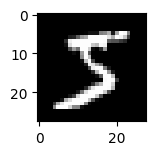

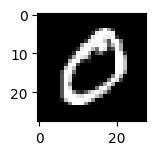

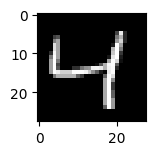

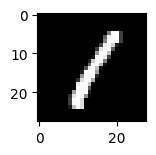

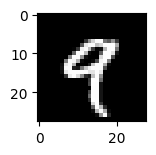

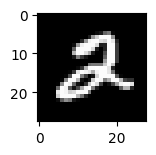

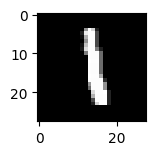

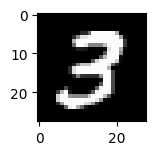

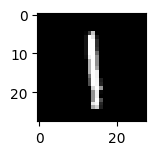

In [37]:
from matplotlib import pyplot

for i in range(9):
  pyplot.subplot(320 + 1 + 1)
  pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [38]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return F.log_softmax(x, dim=1)

In [39]:
def treino(modelo, trainLoader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
  inicio = timer()

  criterio = nn.NLLLoss()
  EPOCHS = 10
  modelo.train()

  for epoch in range(EPOCHS):
    perda_acumulada = 0

    for imagem, etiqueta in trainLoader:
      imagem = imagem.view(imagem.shape[0], -1)

      otimizador.zero_grad()

      saida = modelo(imagem)

      perda_instantanea = criterio(saida, etiqueta.to(device))

      perda_instantanea.backward()

      otimizador.step()

      perda_acumulada += perda_instantanea.item()

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainLoader)))
  print("\nTempo de treino (em minutos) = ", (timer()-inicio)/60)


In [40]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagem, etiqueta in valloader:
    for i in range(len(etiqueta)):
      img = imagem[i].view(1, 784)

      with torch.no_grad():
        logps = modelo(img.to(device))

        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        etiqueta_pred = probab.index(max(probab))
        etiqueta_certa = etiqueta.numpy()[i]
        if(etiqueta_certa == etiqueta_pred):
          conta_corretas += 1
          conta_todas += 1

  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [41]:
transform = transforms.ToTensor()

# Update the URL to a working mirror
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

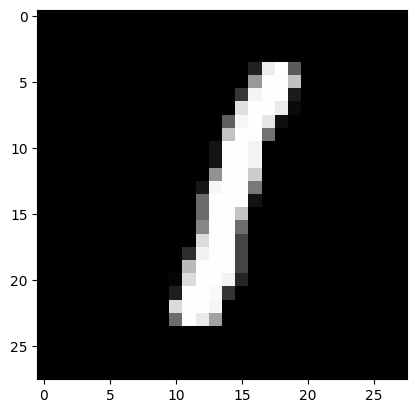

In [42]:
dataiter = iter(trainLoader)
imagem, etiqueta = dataiter.__next__()

plt.imshow(imagem[1].numpy().squeeze(), cmap='Greys_r')

In [43]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [44]:
from timeit import default_timer as timer

caminho_do_modelo = 'modelo_mnist.pth'

modelo_carregado = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_carregado.to(device)
try:
    modelo_carregado.load_state_dict(torch.load(caminho_do_modelo))
    print("Modelo carregado com sucesso para continuar o treinamento!")
except FileNotFoundError:
    print("Arquivo do modelo não encontrado. Iniciando treinamento do zero.")

treino(modelo_carregado, trainLoader, device)

torch.save(modelo_carregado.state_dict(), caminho_do_modelo)

print(f"Modelo (potencialmente) atualizado salvo em: {caminho_do_modelo}")
validacao(modelo_carregado, valloader, device)

Modelo carregado com sucesso para continuar o treinamento!
Epoch 1 - Perda resultante: 1.133209929823367
Epoch 2 - Perda resultante: 0.3751804672483442
Epoch 3 - Perda resultante: 0.3081638066610421
Epoch 4 - Perda resultante: 0.2708534957138079
Epoch 5 - Perda resultante: 0.2409310271856246
Epoch 6 - Perda resultante: 0.21542537402607867
Epoch 7 - Perda resultante: 0.19365097275738524
Epoch 8 - Perda resultante: 0.17536690036283692
Epoch 9 - Perda resultante: 0.16039034175569378
Epoch 10 - Perda resultante: 0.14750550990539002

Tempo de treino (em minutos) =  1.7133490497333337
Modelo (potencialmente) atualizado salvo em: modelo_mnist.pth
Total de imagens testadas = 9569

Precisão do modelo = 100.0%


In [45]:
caminho_do_modelo = 'modelo_mnist.pth'
torch.save(modelo.state_dict(), caminho_do_modelo)

print(f"Modelo salvo em: {caminho_do_modelo}")

Modelo salvo em: modelo_mnist.pth


Etiqueta real: 2
Número previsto pelo modelo: 2
Porcentagem de confiança: 99.92%


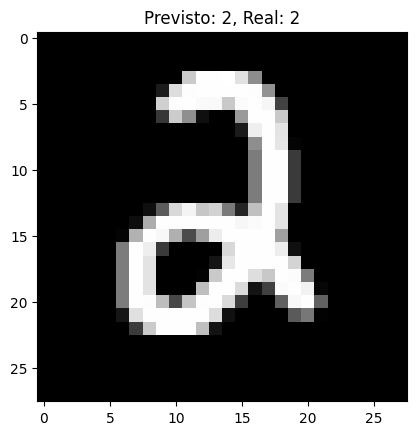

In [46]:
def testar_imagem(modelo, imagem, device):
  img = imagem.to(device)


  img = img.view(1, 784)

  with torch.no_grad():
    logps = modelo(img)

  ps = torch.exp(logps)

  probab = list(ps.cpu().numpy()[0])
  etiqueta_pred = probab.index(max(probab))
  percentagem_acerto = max(probab) * 100

  return etiqueta_pred, percentagem_acerto

dataiter_val = iter(valloader)
imagem_teste, etiqueta_teste = dataiter_val.__next__()

imagem_para_testar = imagem_teste[0]
etiqueta_real = etiqueta_teste[0]

numero_previsto, percentagem_acerto = testar_imagem(modelo_carregado, imagem_para_testar, device)

print(f"Etiqueta real: {etiqueta_real.item()}")
print(f"Número previsto pelo modelo: {numero_previsto}")
print(f"Porcentagem de confiança: {percentagem_acerto:.2f}%")

plt.imshow(imagem_para_testar.cpu().numpy().squeeze(), cmap='Greys_r')
plt.title(f"Previsto: {numero_previsto}, Real: {etiqueta_real.item()}")
plt.show()